# Explainability of Hyperparameters an Example with Decision Trees (Scikit-Learn)

In this tutorial, we will see how to use Hyperparameter optimization to improve the accuarcy of a decision tree classifier.

Then, we will explain the influence of hyperparameters locally, globally through quantitative analysis and visualization.

In [1]:
import matplotlib.pyplot as plt

WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Data

For the data, we use the ``make_moons`` synthetic dataset generator from Scikit-Learn to have a binary-classification problem.

In addition, we randomly flip 10% of the labels to generate artificial noise.

In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# Dataset
def flip_binary_labels(y, ratio, random_state=None):
    """Increase the variance of P(Y|X) by ``ratio``"""
    y_flipped = np.zeros(np.shape(y))
    y_flipped[:] = y[:]
    rs = np.random.RandomState(random_state)
    idx = np.arange(len(y_flipped))
    idx = rs.choice(idx, size=int(ratio * len(y_flipped)), replace=False)
    y_flipped[idx] = 1 - y_flipped[idx]
    return y_flipped


def load_data_train_test(random_state=42):
    noise = 0.1
    n = 1_000
    ratio_flipped = 0.1  # 10% of the labels are flipped

    rng = np.random.RandomState(random_state)

    # Moons
    def make_dataset(n, seed):
        return make_moons(
            n_samples=n,
            noise=noise,
            shuffle=True,
            random_state=seed,
        )

    X, y = make_dataset(n, rng.randint(2**31))
    center = np.mean(X, axis=0)
    X = X - center

    y = flip_binary_labels(y, ratio=ratio_flipped, random_state=rng.randint(2**31))
    y = y.astype(np.int64)

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.33, random_state=rng.randint(2**31), stratify=y
    )

    return (train_X, train_y), (test_X, test_y)


def load_data_train_valid(verbose=0, random_state=42):
    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state, stratify=y
    )

    if verbose:
        print(f"train_X shape: {np.shape(train_X)}")
        print(f"train_y shape: {np.shape(train_y)}")
        print(f"valid_X shape: {np.shape(valid_X)}")
        print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)

train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)


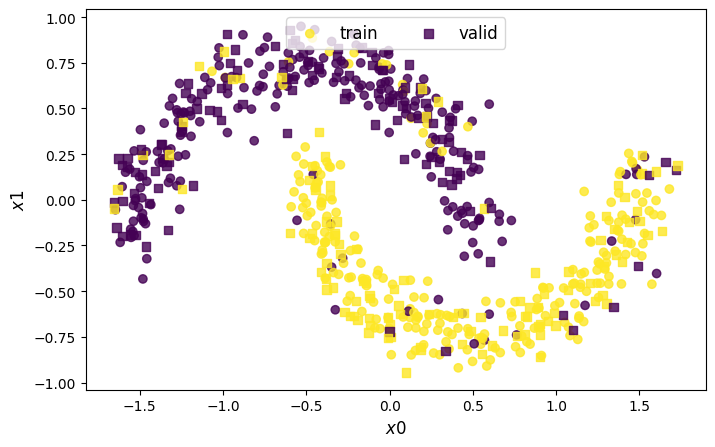

In [3]:
(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx, ty) = load_data_train_test()

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plt.scatter(
    x[:, 0].reshape(-1), x[:, 1].reshape(-1), c=y, label="train", alpha=0.8
)
plt.scatter(
    vx[:, 0].reshape(-1),
    vx[:, 1].reshape(-1),
    c=vy,
    marker="s",
    label="valid",
    alpha=0.8,
)

plt.ylabel("$x1$", fontsize=12)
plt.xlabel("$x0$", fontsize=12)

plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()


## Training and Scoring of Decision Tree

The class of model we use in this tutorial is Decision Tree.

In this part, we will see how to train and evaluate such models.

In [4]:
import pathlib
import pickle
import os

from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")


def run(job, model_checkpoint_dir=".", verbose=True):
    (x, y), (vx, vy) = load_data_train_valid(verbose=verbose)
    _, (tx, ty) = load_data_train_test()

    # We just remove the dummy HP
    model_kwargs = job.parameters.copy()
    model_kwargs.pop("dummy")

    model = DecisionTreeClassifier(**model_kwargs)

    if verbose:
        print(f"{model=}")

    try:
        model.fit(x, y)
        vy_pred_proba = model.predict_proba(vx)
        val_cce = log_loss(vy, vy_pred_proba)
        val_acc = accuracy_score(vy, np.argmax(vy_pred_proba, axis=-1))
    except Exception:
        return "F_fit"

    # Saving the model
    if model_checkpoint_dir is not None:
        with open(os.path.join(model_checkpoint_dir, f"model_{job.id}.pkl"), "wb") as f:
            pickle.dump(model, f)

    if verbose:
        print(f"{job.id}: {val_cce=:.3f}")

    test_cce = log_loss(ty, model.predict_proba(tx))
    test_acc = accuracy_score(ty, model.predict(tx))

    return {
        "objective": val_acc,
        "metadata": {
            "val_cce": val_cce,
            "val_acc": val_acc,
            "test_cce": test_cce,
            "test_acc": test_acc,
        },
    }

## Hyperparameter Optimization Search Space

We now define the hyperparameter optimization search space for decision trees.

In [5]:
from deephyper.hpo import HpProblem


def create_hpo_problem():

    problem = HpProblem()

    problem.add_hyperparameter(["gini", "entropy", "log_loss"], "criterion")
    problem.add_hyperparameter(["best", "random"], "splitter")
    problem.add_hyperparameter((10, 500, "log-uniform"), "max_depth", default_value=500)
    problem.add_hyperparameter((2, 20), "min_samples_split", default_value=2)
    problem.add_hyperparameter((1, 20), "min_samples_leaf", default_value=1)
    problem.add_hyperparameter((0.0, 0.5), "min_weight_fraction_leaf", default_value=0.0)

    # We add a dummy hyperparameter as an indicator for our hyperparameter analysis
    # The idea is that by construction we know this hyperparameter does not have any impact
    # On the performance of our decision tree
    problem.add_hyperparameter((0.0, 1.0), "dummy")

    return problem

create_hpo_problem()

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    dummy, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    max_depth, Type: UniformInteger, Range: [10, 500], Default: 500, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

## The Baseline Decision Tree

Now, we evaluate the baseline Decision Tree model by test `default_value` hyperparameters.

In [31]:
from deephyper.evaluator import RunningJob


def evaluate_decision_tree(
    parameters=None,
    verbose=True,
    model_checkpoint_dir=model_checkpoint_dir,
):
    model_checkpoint_dir = "models_sklearn_test"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    default_parameters = problem.default_configuration
    if verbose and parameters is None:
        print("Using default parameters!")
        parameters = default_parameters

    if verbose:
        print(f"{parameters=}")

    output = run(
        RunningJob(id="test", parameters=parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        verbose=verbose,
    )

    if verbose:
        print(f"\nPerformance Metrics\n{'-' * 20}\n")
        print(
            f"Validation Categorical CrossEntropy: {output['metadata']['val_cce']:.3f}"
        )
        print(
            f"Validation Accuracy                : {output['metadata']['val_acc']:.3f}"
        )
        print()
        print(
            f"Test       Categorical CrossEntropy: {output['metadata']['test_cce']:.3f}"
        )
        print(
            f"Test       Accuracy                : {output['metadata']['test_acc']:.3f}"
        )

    return output

In [32]:
baseline_output = evaluate_decision_tree()

Using default parameters!
parameters={'criterion': 'gini', 'dummy': 0.5, 'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)
model=DecisionTreeClassifier(max_depth=500)
0.0: val_cce=6.007

Performance Metrics
--------------------

Validation Categorical CrossEntropy: 6.007
Validation Accuracy                : 0.833

Test       Categorical CrossEntropy: 6.663
Test       Accuracy                : 0.815


## Hyperparameter Optimization

In [8]:
from deephyper.hpo import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback
from deephyper.evaluator.callback import SearchEarlyStopping


def run_hpo():

    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    evaluator = Evaluator.create(
        run,
        method="thread",
        method_kwargs={
            # "num_cpus": 1,
            # "num_cpus_per_task": 1,
            "num_workers": 8,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [
                TqdmCallback(),
                # SearchEarlyStopping(patience=50),
            ]
        },
    )
    search = CBO(
        problem,
        evaluator,
        log_dir=hpo_dir,
        initial_points=[problem.default_configuration],
        n_initial_points=20,
        surrogate_model="ET", # Use Extra Trees as surrogate model
        surrogate_model_kwargs={
            "n_estimators": 25, # Relatively small number of trees in the surrogate to make it "fast"
            "min_samples_split": 8, # Larger number to avoid small leaf nodes (smoothing the response)
        },
        acq_func="UCBd",
        # acq_optimizer="mixedga",
        # acq_optimizer_freq=1,
        # kappa=1.96,
        kappa=5.0,
        scheduler={"type": "periodic-exp-decay", "period": 50, "kappa_final": 0.0001},
        objective_scaler="identity",
    )

    results = search.search(max_evals=450)

    return search, results

In [9]:
search, results = run_hpo()

/Users/romainegele/Documents/Argonne/deephyper/src/deephyper/evaluator/_evaluator.py:148: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn("Applying nest-asyncio patch for IPython Shell!", category=UserWarning)


  0%|          | 0/450 [00:00<?, ?it/s]

In [10]:
results

,p:criterion,p:dummy,p:max_depth,p:min_samples_leaf,p:min_samples_split,p:min_weight_fraction_leaf,p:splitter,objective,job_id,job_status,m:timestamp_submit,m:val_cce,m:val_acc,m:test_cce,m:test_acc,m:timestamp_gather
0,gini,0.500000,500,1,2,0.000000,best,0.819820,0,DONE,0.021445,6.494352,0.819820,6.444168,0.821212,0.054842
1,gini,0.358886,196,2,6,0.037803,random,0.855856,1,DONE,0.021478,1.337372,0.855856,1.017436,0.775758,0.131057
2,gini,0.430910,12,4,17,0.172674,random,0.702703,3,DONE,0.021499,0.569173,0.702703,0.586764,0.687879,0.132598
3,gini,0.908113,61,5,6,0.395256,best,0.783784,2,DONE,0.021490,0.511322,0.783784,0.548213,0.760606,0.132825
4,log_loss,0.624588,364,16,15,0.090525,best,0.806306,4,DONE,0.021507,1.102714,0.806306,0.801667,0.787879,0.132969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,entropy,0.805220,46,5,19,0.012772,best,0.864865,449,DONE,33.048469,2.916276,0.864865,2.999895,0.851515,33.153435
453,log_loss,0.734555,50,5,18,0.003502,random,0.887387,455,DONE,33.048523,2.305316,0.887387,2.516469,0.866667,33.153526
454,log_loss,0.699995,20,8,20,0.013099,best,0.869369,454,DONE,33.048516,2.929503,0.869369,2.918305,0.845455,33.153612
455,entropy,0.301841,14,6,19,0.007503,best,0.864865,453,DONE,33.048510,2.916276,0.864865,2.999895,0.851515,33.153697


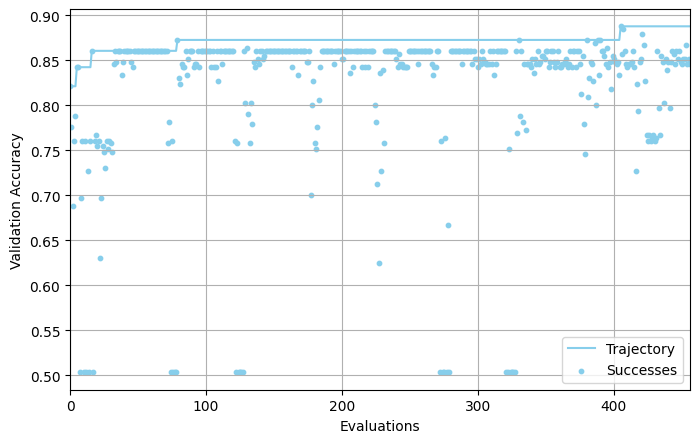

In [11]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo


plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_search_trajectory_single_objective_hpo(results, column="m:test_acc", mode="max")
plt.ylabel("Validation Accuracy")
plt.grid(which="minor", linestyle="--")
plt.show()

## Hyperparameter importance and interactions

To explain the impact of our hyperparameter, we start by loading the surrogate model from the Bayesian optimization and we re-fit it on our target objective value of interest.
In this example, we use the test accuracy as variations in accuracy are easier for interpretation.

Then, we look at the MSE of our surrogate model to evaluate if it is underfitting.

In [12]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score

surrogate_model = search.get_surrogate_model(estimator=ExtraTreesRegressor(min_samples_split=8, max_depth=300))
hyperparameter_names = surrogate_model.hyperparameter_names

X = results[[f"p:{n}" for n in hyperparameter_names]].values
y = results["m:test_acc"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
surrogate_model.fit(X_train, y_train)

mse_train = surrogate_model.evaluate(X_train, y_train)
mse_test = surrogate_model.evaluate(X_test, y_test)
y_pred = surrogate_model.predict(X)

print(f"Training R2 of the Surrogate Model: {mse_train:.3f}")
print(f"Test     R2 of the Surrogate Model: {mse_test:.3f}")

scores = cross_val_score(surrogate_model.estimator, X=surrogate_model.transform(X), y=y, cv=10)
scores_mean = np.mean(scores)
scores_std = np.std(scores)
print(f"{scores_mean:.3f} ± {scores_std:.3f}")


Training R2 of the Surrogate Model: 0.939
Test     R2 of the Surrogate Model: 0.833
0.696 ± 0.328


The training and test MSE of the surrogate model gives us an idea of the surrogate model underfitting or overfitting the results data. 
Both of these situations have to be checked and mitigated if they appear. 
In our case both values are close so it seems okay.
Also, from our Validation CCE vs Evaluations plot it is good to note that many objectives are close in value.

After, fitting the model on our objective value we can look at the hyperparameter importance (based on permutation importance algorithm of the surrogate model).

In [13]:
print("Hyperparameter importance:")
hp_imp = surrogate_model.hyperparameter_importance(X, y, n_repeats=20)
important_hyperparameters = []
for hp_name, val in hp_imp.items():
    prefix = ""
    if val["mean"] - 2 * val["std"] > 0:
        prefix = " +++ "
        important_hyperparameters.append(hp_name)
    else:
        prefix = " --- "
    print(f"{prefix}{hp_name}: {val['mean']:.3f} ± {val['std']:.3f}")


Hyperparameter importance:
 +++ min_weight_fraction_leaf: 0.902 ± 0.068
 +++ splitter: 0.446 ± 0.043
 +++ criterion: 0.029 ± 0.012
 +++ min_samples_leaf: 0.022 ± 0.002
 +++ dummy: 0.011 ± 0.004
 +++ max_depth: 0.010 ± 0.002
 +++ min_samples_split: 0.009 ± 0.002


The hyperparameter importance values is a global explaination. 
It gives us an idea of how each hyperparameter impacts the objective of interest (here the test accuracy) globally in our collected results. 
These quantities are sensitive to the process generating the results (Random search, Bayesian optimization, etc...) and the surrogate model used. 
They cannot be generalized easily and must be interpreted with caution. 

We sorted the hyperparameter importance values in decreasing order.

We can see that our `dummy` hyperparameter is among the least important ones which is a good sanity check to identify importance value that are not significant. In this case, reducing it to at least the size of the training set.

An other good sanity check is to see that `max_depth` is not very important. Indeed, the range of `max_depth` is significantly larger than the dataset training set! Making most of this range unimportant. Observing this can help you refine your hyperparameter ranges.

Now that we have a global understanding of hyperparameter sensitivity we can look for local explainations of the top configurations.

For this we use the `shapiq` package:

```bash
pip install shapiq
```

In this plot, the __base__ value corresponds to the expected objective value $E_{\Theta}[f(\Theta)]$ where $f$ is our `run`-function and $\Theta$ is a random variable describing a configuration of hyperparameters (according to the search algorithm used!).

https://shapiq.readthedocs.io/en/latest/notebooks/basics_notebooks/sv_calculation.html#Shapley-Values-for-Local-Feature-Attribution

Test Acc.: 0.888 for parameters: {'criterion': 'log_loss', 'dummy': 0.6348376418274714, 'max_depth': 118, 'min_samples_leaf': 5, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0104446039800251, 'splitter': 'random'}


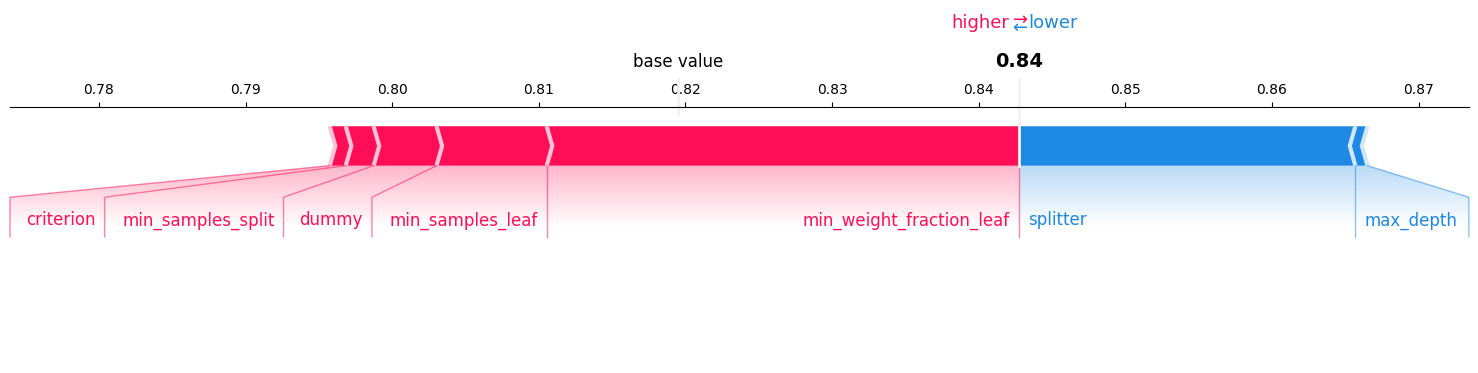

In [25]:
import warnings
import shapiq

from deephyper.analysis.hpo import parameters_from_row

topk = results.nlargest(columns=["m:test_acc"], n=1).index.values

X_transformed = surrogate_model.transform(X)

explainer = shapiq.TabularExplainer(
    model=surrogate_model.estimator,
    data=X_transformed,
    index="SV",  # Shapley values
    max_order=1,
    imputer="marginal",
    # imputer="conditional",
    # sample_size=100,
)

for i in topk:
    params = parameters_from_row(results.loc[i])
    value = results.loc[i, "m:test_acc"]
    print(f"Test Acc.: {value:.3f} for parameters: {params}")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        shapley_values = explainer.explain(X_transformed[i], budget=1024)
        shapley_values.plot_force(feature_names=hyperparameter_names, abbreviate=False)
        # shapley_values.plot_waterfall(feature_names=hyperparameter_names, abbreviate=False)

Test Acc.: 0.888 for parameters: {'criterion': 'log_loss', 'dummy': 0.6348376418274714, 'max_depth': 118, 'min_samples_leaf': 5, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0104446039800251, 'splitter': 'random'}


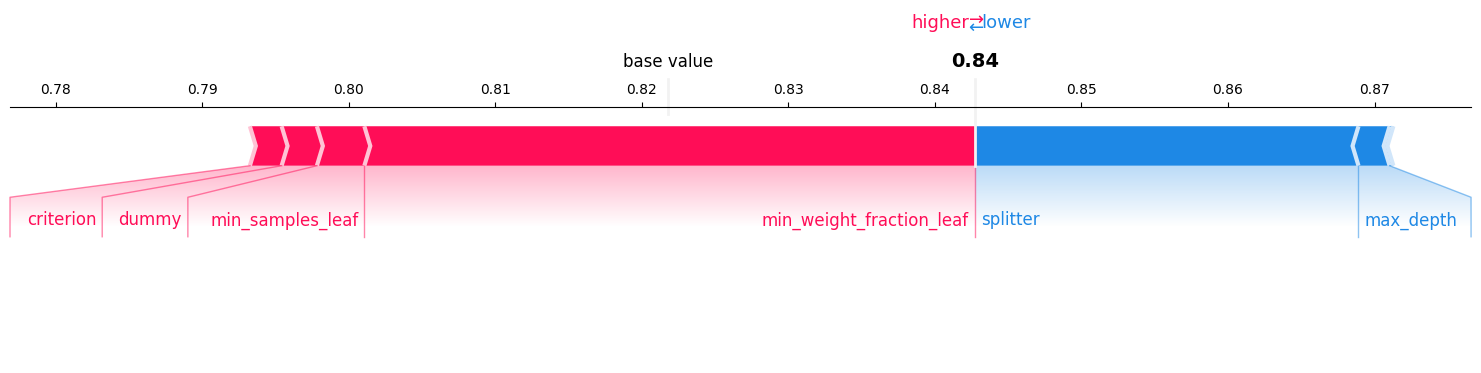

In [26]:
import warnings
import shapiq

from deephyper.analysis.hpo import parameters_from_row


topk = results.nlargest(columns=["m:test_acc"], n=1).index.values

X_transformed = surrogate_model.transform(X)

explainer = shapiq.TreeExplainer(
    model=surrogate_model.estimator,
    data=X_transformed,
    index="SV",  # Shapley values
    max_order=1,
    # imputer="marginal",
    # imputer="conditional",
    # sample_size=100,
)

for i in topk:
    params = parameters_from_row(results.loc[i])
    value = results.loc[i, "m:test_acc"]
    print(f"Test Acc.: {value:.3f} for parameters: {params}")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        shapley_values = explainer.explain(X_transformed[i], budget=1024)
        shapley_values.plot_force(feature_names=hyperparameter_names, abbreviate=False)
        
        # shapley_values.plot_waterfall(feature_names=hyperparameter_names, abbreviate=False)

In [21]:
# Evaluation of the mean accuracy and STD
outputs = []
n_repetitions = 100
for _ in range(n_repetitions):
    params = parameters_from_row(results.loc[topk[0]])
    outputs.append(evaluate_decision_tree(params, verbose=False, model_checkpoint_dir=None))

scores = [out["metadata"]["test_acc"] for out in outputs]
mean_scores = np.mean(scores)
std_scores = np.std(scores)
stde_scores = std_scores / np.sqrt(n_repetitions)
print(f"{mean_scores:.3f} ± {std_scores:.3f} with stde={stde_scores:.3f}")

0.842 ± 0.033 with stde=0.003


0.8696969696969697


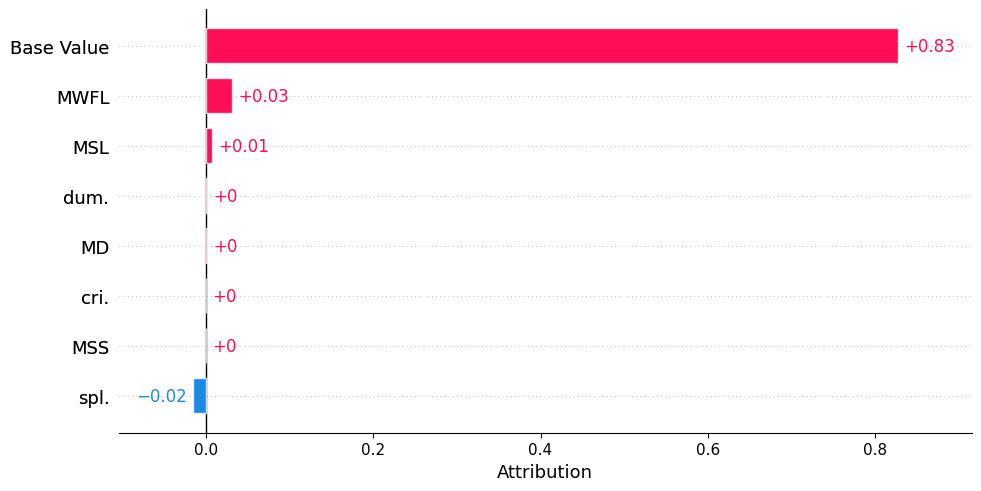

In [ ]:
# A more global analysis over top performing hyperparameters
import shapiq


results_nlargest = results.nlargest(columns=["m:test_acc"], n=20)
topk = results_nlargest.index.values
print(np.min(results_nlargest["m:test_acc"]))

explainer = shapiq.TabularExplainer(
    model=surrogate_model,
    data=X,
    index="SV",  # Shapley values
    max_order=1,
    # index="k-SII",  # k-SII interaction values
    # max_order=2     # specify any order you want
    # imputer="marginal",
    # sample_size=100,
)

list_of_interaction_values = explainer.explain_X(X[topk])
shapiq.plot.bar_plot(list_of_interaction_values, feature_names=hyperparameter_names, show=True)

Training R2 of the Surrogate Model: 1.000
Test     R2 of the Surrogate Model: 1.000
Test Acc.: 0.882 for parameters: {'criterion': 'log_loss', 'dummy': 0.5792014396848527, 'max_depth': 999, 'min_samples_leaf': 8, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0010294435710572, 'splitter': 'random'}


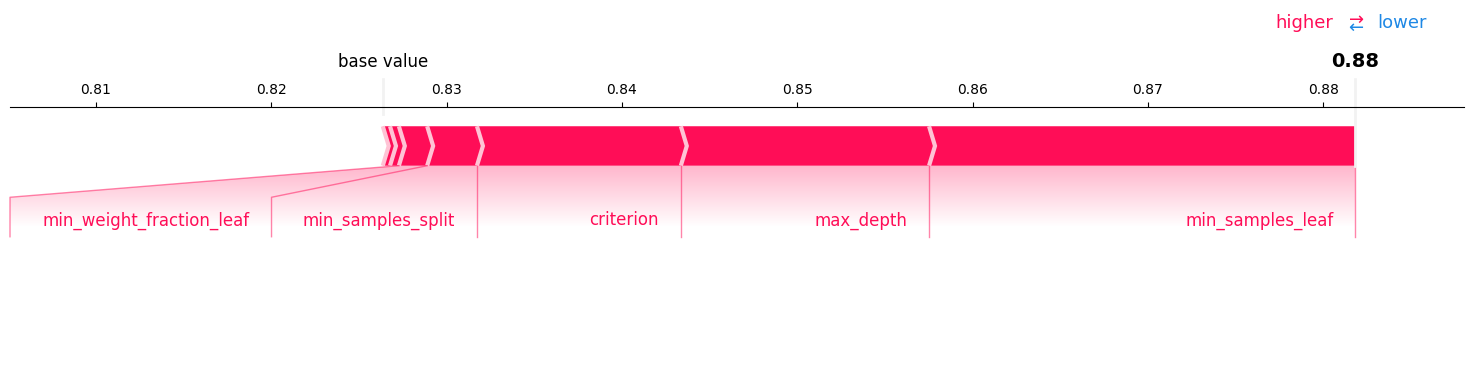

Test Acc.: 0.879 for parameters: {'criterion': 'log_loss', 'dummy': 0.9760038696611076, 'max_depth': 611, 'min_samples_leaf': 6, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0016802193809535, 'splitter': 'random'}


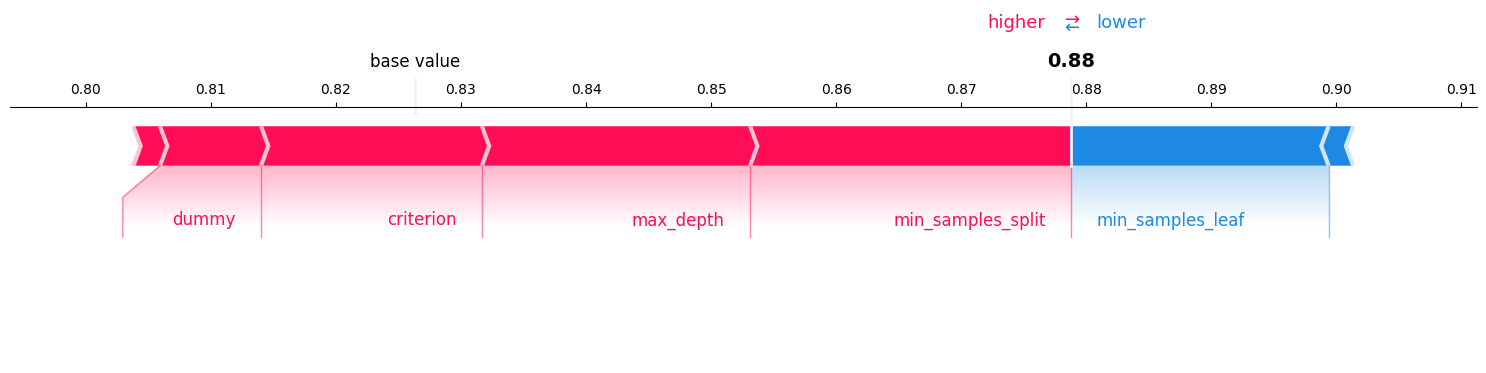

Test Acc.: 0.879 for parameters: {'criterion': 'log_loss', 'dummy': 0.9508084277856867, 'max_depth': 134, 'min_samples_leaf': 4, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0065203086188848, 'splitter': 'random'}


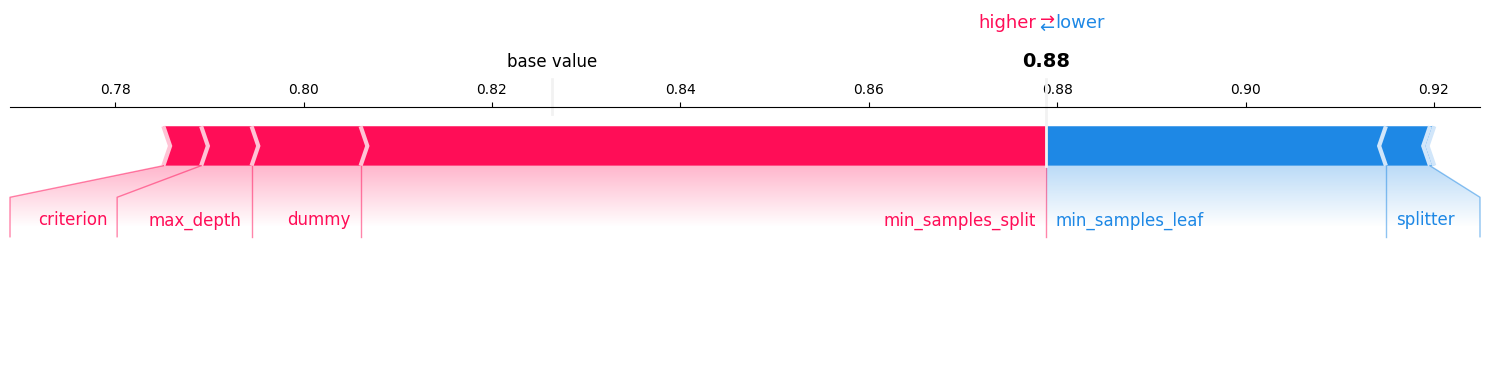

Test Acc.: 0.876 for parameters: {'criterion': 'log_loss', 'dummy': 0.5737170091782905, 'max_depth': 968, 'min_samples_leaf': 5, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.007271764308751, 'splitter': 'random'}


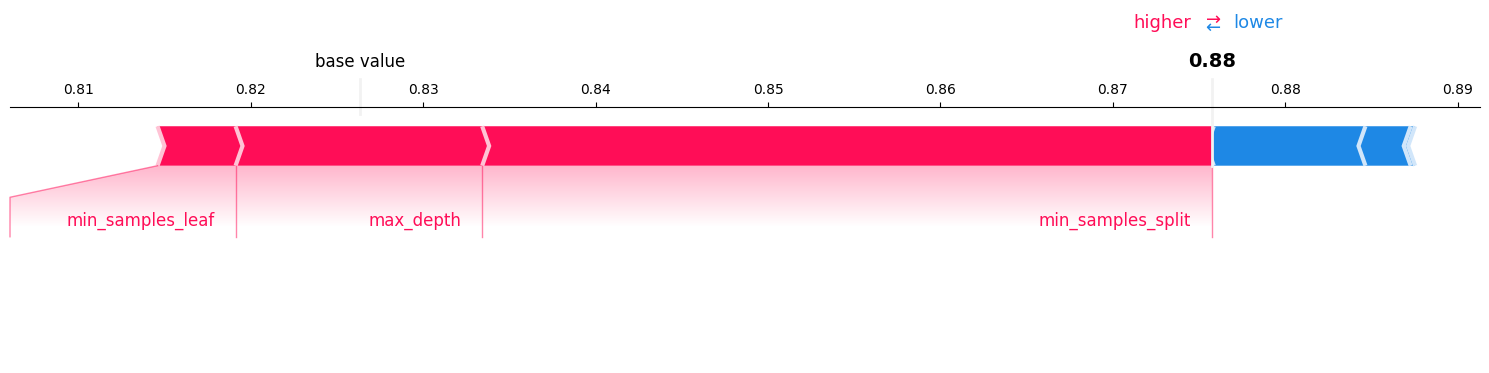

Test Acc.: 0.876 for parameters: {'criterion': 'log_loss', 'dummy': 0.6360845083842434, 'max_depth': 969, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0080276696899488, 'splitter': 'random'}


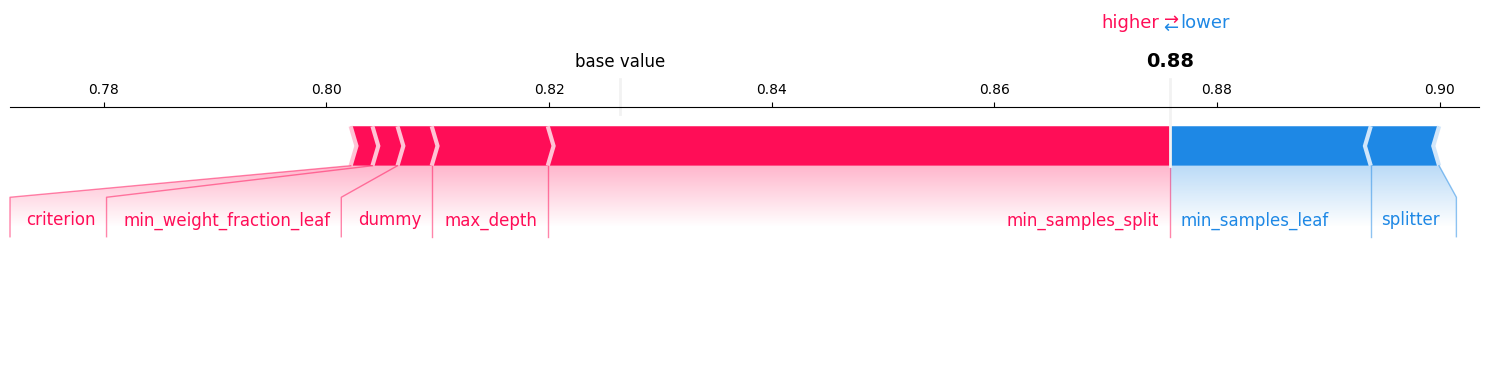

In [110]:
from sklearn.neighbors import KNeighborsRegressor

knn_estimator = KNeighborsRegressor(n_neighbors=1)
surrogate_model.estimator = knn_estimator

surrogate_model.fit(X, y)

score_train = surrogate_model.evaluate(X_train, y_train)
score_test = surrogate_model.evaluate(X_test, y_test)
y_pred = surrogate_model.predict(X)

print(f"Training R2 of the Surrogate Model: {score_train:.3f}")
print(f"Test     R2 of the Surrogate Model: {score_test:.3f}")

topk = results.nlargest(columns=["m:test_acc"], n=5).index.values

explainer = shapiq.TabularExplainer(
    model=surrogate_model,
    data=X,
    index="SV",  # Shapley values
    max_order=1,
    imputer="marginal",
    sample_size=100,
)

for i in topk:
    params = parameters_from_row(results.loc[i])
    value = results.loc[i, "m:test_acc"]
    print(f"Test Acc.: {value:.3f} for parameters: {params}")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        shapley_values = explainer.explain(X[i], budget=1024)
        shapley_values.plot_force(feature_names=hyperparameter_names, abbreviate=False)
        # shapley_values.plot_waterfall(feature_names=hyperparameter_names, abbreviate=False)

In [48]:
results["m:test_acc"].mean()

0.7655568846358322

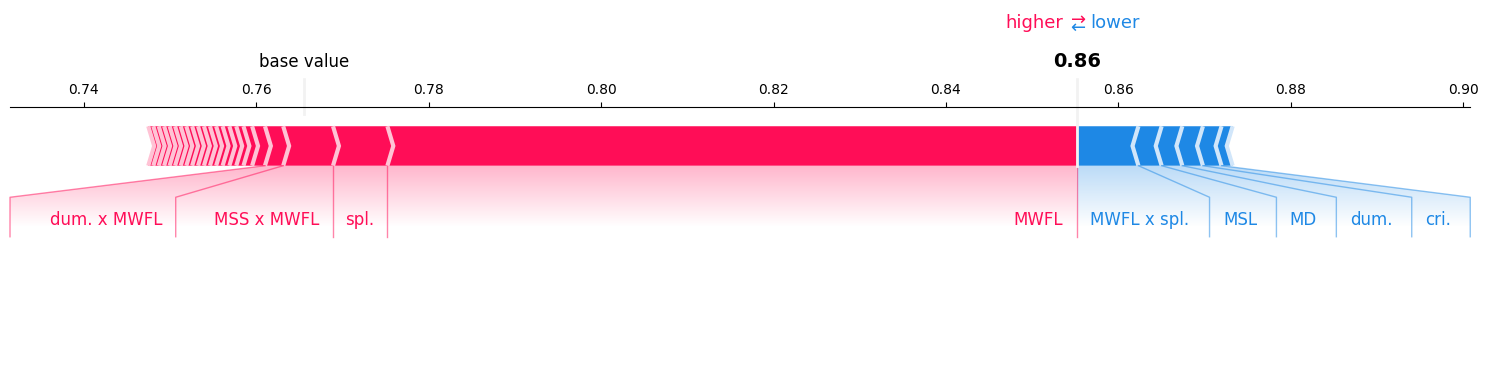

In [21]:
explainer = shapiq.Explainer(
    model=surrogate_model,
    data=X,
    index="k-SII",  # k-SII interaction values
    max_order=2     # specify any order you want
)

for i in topk:
    interaction_values = explainer.explain(X[i])
    interaction_values.plot_force(feature_names=hyperparameter_names, abbreviate=True)

## Hyperparameter Visualization

For an interactive visualization of your hyperparameter optimization results we suggest to use [Visual Studio Code](https://code.visualstudio.com) with the [SandDance Extension](https://marketplace.visualstudio.com/items?itemName=msrvida.vscode-sanddance).

First, open your `results.csv` file. Then, right click on the file name (colored in light green on the image) and select "View in SandDance" (colored in red on the image).

<img src="figures/open_sanddance.png" alt="Open SandDance" width="60%"/>

To do a density plot, on the top of the left sidebar, select "Density".

To put the plot in 3 dimensions. On the top right of the screen, on the right of "camera" logo, click on the little "cube" (it should move to 3D and the cube logo should become a paper sheet logo to move back to 2 dimensions).

Then go back to the left sidebar.

Select `"p:splitter"` for the *X Axis*.

Select `"p:min_weight_fraction_leaf"` for the *Y Axis*.

Select `"m:test_acc"` for the *Z Axis*.

Select `"m:test_acc"` for the *Color by*.

Select `"m:test_acc"` for the *Sort by*.

On the left of the left side bar, click on the color palet logo, bellow the chart logo (it should be the second from the top).

Select `"None (continuous)"` in the *COLOR BINNING* section.

See the bellow image.

<img src="figures/plot_density_mwfl_splitter_color.png" alt="Plot Color of Density MWFL x Splitter" width="20%"/>


You should now have the following plot.

<img src="figures/plot_density_mwfl_splitter.png" alt="Plot Density MWFL x Splitter" width="60%"/>

## The Best Decision Tree

In [65]:
from deephyper.analysis.hpo import parameters_from_row

topk_rows = results.nlargest(5, "m:test_acc").reset_index(drop=True)

for i, row in topk_rows.iterrows():
    parameters = parameters_from_row(row)
    value = row["m:test_acc"]
    print(f"Top-{i+1} -> {value=:.3f}: {parameters}")
    print()

Top-1 -> value=0.876: {'criterion': 'log_loss', 'dummy': 0.6981437315065057, 'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 19, 'min_weight_fraction_leaf': 0.0018813748849678, 'splitter': 'best'}

Top-2 -> value=0.861: {'criterion': 'entropy', 'dummy': 0.4211446647333435, 'max_depth': 241, 'min_samples_leaf': 20, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.0122283215702675, 'splitter': 'best'}

Top-3 -> value=0.861: {'criterion': 'log_loss', 'dummy': 0.6914196437895164, 'max_depth': 339, 'min_samples_leaf': 9, 'min_samples_split': 12, 'min_weight_fraction_leaf': 1.709754755583313e-05, 'splitter': 'random'}

Top-4 -> value=0.861: {'criterion': 'log_loss', 'dummy': 0.211975804255767, 'max_depth': 19, 'min_samples_leaf': 7, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0510050722680392, 'splitter': 'best'}

Top-5 -> value=0.861: {'criterion': 'entropy', 'dummy': 0.7326782334929811, 'max_depth': 732, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weig

In [66]:
best_job = topk_rows.iloc[0]

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

with open(os.path.join(model_checkpoint_dir, f"model_0.{best_job.job_id}.pkl"), "rb") as f:
    best_model = pickle.load(f)

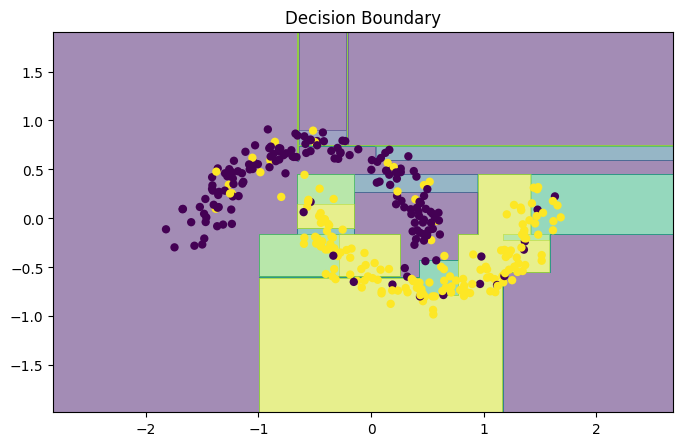

In [67]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.title("Decision Boundary")
plot_decision_boundary_decision_tree(
    tx, ty, best_model, steps=1000, color_map="viridis"
)
plt.show()